In [26]:
import os
import matplotlib as mpl
import matplotlib.pylab as plt
import itertools
import csv , codecs
import glob
from PIL import Image
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn import decomposition
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss


In [27]:
data_dir = "./EEG_data/"

## CSV 파일 생성 함수

In [28]:
def EEG_data_csv(data_dir):
    
    # Kinds of Power 입력
    file_list = os.listdir(data_dir)
    file_list.sort()
       
    global kinds_of_power
    kinds_of_power = "Relative"
    
    excel_dir = "./EEG_data" + '/' + kinds_of_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    # EEG_csv_data 디렉토리 생성
    csv_dir = "./EEG_csv_data"
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    
    Abs_dir ="./EEG_csv_data/Abs"
    Relative_dir = "./EEG_csv_data/Relative"
    
    if not os.path.isdir(Abs_dir):
        os.mkdir(Abs_dir)
    if not os.path.isdir(Relative_dir):
        os.mkdir(Relative_dir)
    
    book = Workbook()
    sheet = book.active
    
    # x축,y축 생성
    for i in range (1,21) :
        if i < 10 :
            sheet['A'+str(i+1)] = 'S0'+str(i)
        if i == 10 :
            sheet['A'+str(i+1)] = 'S'+str(10)
        if i > 10 :
            sheet['A'+str(i+1)] = 'S'+str(i)
            
    for j in range (0,12):
        for i in range(1,33):
            sheet.cell(row=1, column=160*j+i+1).value = 'ACh' + str(i)
            sheet.cell(row=1, column=160*j+i+33).value = 'BCh' + str(i)
            sheet.cell(row=1, column=160*j+i+65).value = 'DCh' + str(i)
            sheet.cell(row=1, column=160*j+i+97).value = 'GCh' + str(i)
            sheet.cell(row=1, column=160*j+i+129).value = 'TCh' + str(i)

    # 파일을 순차적으로 열어서 셀 영역을 복사
    # j: 엑셀 파일의 수, k: 각 엑셀 파일 당 시트의 수, n: task의 수, l: subject의 수, m: ch1-ch32

    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=l,column=160*k+m+32*j).value = source.cell(row=l,column=m).value

    # EEG_csv_data 디렉토리에 csv 파일로 저장
    if kinds_of_power == "Abs":
        with open(Abs_dir + str('/') +'Abs_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])
    elif kinds_of_power == "Relative":
        with open(Relative_dir + str('/') +'Relative_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])

## CSV 파일에서 Pandas dataframe으로 가져오는 함수

In [29]:
def data_setting(task, eye , respiratory):
    # 성재가 만든 파일 불러오는 경로 입력 및 데이터 프레임으로 불러올것 
    ##  Abs, Relative 설정은 여기서 변경하기기
    csv_name = "./EEG_csv_data/Abs/Abs_Merged.csv"
    data = pd.read_csv(csv_name) 
    data_column = data.columns
    
    
    # 1 back
    if task == 0 : 
        if respiratory == 0 :
            data = data[data_column[1:161]]
            # 1-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            
            
            
        elif respiratory == 1 :
            data = data[data_column[161:321]]
            # 1-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[321:481]]
            # 1-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    # 2 back
    elif task == 1 : 
        if respiratory == 0 :
            data = data[data_column[481:641]]
            # 2-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 1 :
            data= data[data_column[641:801]]
            # 2-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[801:961]]
            # 2-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    #resting
    elif task == 2 :
        ## eye ==0 close eye
        if eye == 0 :
            if respiratory == 0 :
                data = data[data_column[961:1121]]
                # resting open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1121:1281]]
                # resting open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1281:1441]]
                # resting open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
        ## eye ==1 open eye
        if eye == 1 : 
            if respiratory == 0 :
                data = data[data_column[1441:1601]]
                # resting close eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1601:1761]]
                # resting close eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1761:1921]]
                # resting close eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))

    
    
    
    
    return data
                
                
# column indexing task condition

### dataset 만드는 함수

In [30]:
def dataset_csv():
    normalize_power = str(input("Relative, Abs :"))
    excel_dir = "./EEG_data" + '/' + normalize_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    subject = int(input("subject :"))
    

    book = Workbook()
    sheet = book.active
    sheet.cell(row=1, column=161).value = 'target'
 
    # x축 생성   
    for i in range(1,33):
        sheet.cell(row=1, column=i).value = 'ACh' + str(i)
        sheet.cell(row=1, column=i+32).value = 'BCh' + str(i)
        sheet.cell(row=1, column=i+64).value = 'DCh' + str(i)
        sheet.cell(row=1, column=i+96).value = 'GCh' + str(i)
        sheet.cell(row=1, column=i+128).value = 'TCh' + str(i)
        
    # 파일을 순차적으로 열어서 셀 영역을 복사
    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=20*k+l,column=32*j+m-1).value = source.cell(row=l,column=m).value
        

    with open('./dataset_eeg.csv', 'w', newline="") as f:
        c = csv.writer(f)
        for r in sheet.rows:
            c.writerow([cell.value for cell in r])
            
    df = pd.read_csv('./dataset_eeg.csv')
    df[df =='                      NaN'] =np.nan
    df = df.fillna(0.0).astype('float64')
    pd.options.mode.chained_assignment = None

    df["target"][0*subject:1*subject] = "010"
    df["target"][1*subject:2*subject] = "011"
    df["target"][2*subject:3*subject] = "012"

    df["target"][3*subject:4*subject] = "110"
    df["target"][4*subject:5*subject] = "111"
    df["target"][5*subject:6*subject] = "112"

    df["target"][6*subject:7*subject] = "200"
    df["target"][7*subject:8*subject] = "201"
    df["target"][8*subject:9*subject] = "202"

    df["target"][9*subject:10*subject] = "210"
    df["target"][10*subject:11*subject] = "211"
    df["target"][11*subject:12*subject] = "212"
    df.astype('float64')
    df.to_csv('./dataset_eeg.csv')
    
    return df

In [31]:
eeg_data = dataset_csv()

Relative, Abs : Relative
subject : 20


C:\Users\whbom\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [32]:
eeg_data

,ACh1,ACh2,ACh3,ACh4,ACh5,ACh6,ACh7,ACh8,ACh9,ACh10,...,TCh24,TCh25,TCh26,TCh27,TCh28,TCh29,TCh30,TCh31,TCh32,target
0,4.512153,2.236848,16.237565,8.485316,23.868040,8.095887,61.092520,63.790479,68.686679,69.925212,...,8.735276,0.828638,1.010004,1.778969,6.435780,14.978180,11.507832,11.162954,9.491918,010
1,4.539769,4.310226,4.959007,3.965357,7.222414,5.466902,16.751086,19.945360,30.425709,24.128985,...,18.794290,9.741533,7.106003,10.521237,8.559514,18.069939,15.457455,22.764836,22.393518,010
2,9.876811,9.070304,3.572186,4.272411,12.559673,19.156709,26.778865,17.134912,53.187562,49.574373,...,11.408656,6.724140,8.721257,10.193054,2.678986,11.522934,11.118133,11.282202,10.760432,010
3,4.224107,6.190282,8.670873,8.869054,25.241644,20.749929,40.968150,43.190059,42.509827,41.379676,...,10.493111,4.743475,5.994422,2.769252,5.845854,11.149340,12.461344,12.748985,11.845096,010
4,18.441049,19.286110,8.901129,12.888736,7.272771,15.879294,23.182914,38.046045,29.140603,32.524267,...,14.825606,16.428830,15.406232,16.088470,17.454960,18.750681,17.095190,13.764769,13.443134,010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9.377716,6.913374,5.995995,4.562073,6.141009,6.275420,17.190073,19.530794,29.798448,27.170256,...,5.781882,11.865520,10.328138,10.171290,11.796915,15.583215,16.539841,15.194092,14.108681,212
236,11.906533,10.057115,11.180124,11.478218,14.621087,16.359638,26.560596,24.297633,30.679741,26.798845,...,16.024479,6.548399,6.806564,10.569691,14.455136,15.406702,16.142647,14.712165,14.551317,212
237,10.335814,8.589677,13.796878,13.048695,25.629270,24.416874,33.204969,34.318945,29.184918,28.485295,...,24.964200,19.061720,18.617480,16.023406,20.075270,26.804320,25.657373,24.098649,19.401579,212
238,14.781336,13.040448,5.557476,4.101700,19.404795,10.489655,27.480708,24.014191,32.643752,30.794355,...,20.821745,9.054677,14.631369,11.264431,17.292341,19.074393,22.937862,23.429094,12.989213,212


-------------------------------------------

# **train set에 관한 feature 160의 variances, importanace 계산**

### 1. VarianceThreshold(VT)를 이용한 variance 접근 방식

* 임계값을 충족하지 않는 모든 feature을 제거하는 방식
    - 기본값은 분산이 0이 아닌 모든 feature을 유지하는 것
* VT의 변수의 분산 계산 방법
    - $$ \ {Var} [X] = \frac{1}{n} {\sum_{i=1}^{n}(x_i - \mathbf{u})^2} $$
    - x는 특성벡터, $x_i$는 개별 feature값, $\mathbf{u}$는 feature의 평균값
    
    
* .variance_ 속성에서 각 특성의 분산을 확인할 수 있음   

### 2. Random forest classification을 사용하여 feature importance 접근

* **RandomForest feature importance는 DecisionTree importance를 feature 별로 평균화해서 feature importance를 구함**

    - 최종적으로 feature importance의 합이 1이 되도록 정규화함
    
    - DecisionTree에서 node 하나의 importance는 다음과 같이 계산함
        + 
        $$
        \frac{\mathbf{n}_p \times \mathbf{I}_p - (\mathbf{n}_l \times \mathbf{I}_l + \mathbf{n}_r \times \mathbf{I}_r )}{\mathbf{n}}
        $$
        + $\mathbf{n}_p$와$\mathbf{I}_p$는 각각 상위 node의 sample개수와 불순도
        + $\mathbf{n}_l$와 $\mathbf{I}_l$는 왼쪽 node, $\mathbf{n}_r$와 $\mathbf{I}_r$는 오른쪽 node의 sample개수와 불순도
    - $\mathbf{I}$는 gini impurity를 활용
        + ${\sum_{j=1}^{J}({p_j}(1-{p_j})}$
        + 집합에서 class j를 선택할 확률

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

X = eeg_data.iloc[:,0:-1]
X1=np.array(X)
Y = eeg_data['target']
Y1= np.array(Y)


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

#vt분산 계산
thresholder=VarianceThreshold()
variances=thresholder.fit(X_train)

#Randomforest 사용 
rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

# VT.variance와 Randomforest.feature_importances_
d1_train=dict(zip(X.columns.tolist(), list(variances.variances_)))
d2_train=dict(zip(X.columns.tolist(), list(rnd_clf.feature_importances_)))

#ch명, 분산, 중요도 순
for name, variance, importance in zip(X.columns.tolist(), d1_train.values(), d2_train.values() ):
    print(name, variance, importance)

ACh1 24.9742856955811 0.007412632872019211
ACh2 28.494850761797917 0.005513938999097245
ACh3 29.136138202772436 0.006365783782971198
ACh4 29.220829872925744 0.006526082704575775
ACh5 46.702028656619184 0.00486986764910631
ACh6 41.84621867765508 0.006013688524927142
ACh7 68.1628038064602 0.006442565694131241
ACh8 73.23761846346146 0.006576768340185154
ACh9 73.49989886881383 0.008208743414461248
ACh10 77.4780650005016 0.009194095118577224
ACh11 35.559490246336196 0.005442189366468984
ACh12 33.717913934066786 0.005783609504822141
ACh13 46.63048357284951 0.005902558651360558
ACh14 51.30137928883607 0.005555709597999095
ACh15 65.22511440757512 0.00571067534372873
ACh16 69.3518316795425 0.0060319660021872275
ACh17 41.32121977982774 0.006998607977909223
ACh18 0.0 0.0
ACh19 57.342975191284935 0.005253335407182418
ACh20 77.96187387432465 0.007935026470503306
ACh21 35.531973064443754 0.005246696143097165
ACh22 37.39653776587193 0.005721437118872649
ACh23 61.46535640790887 0.005738987955838745
AC

In [36]:
def f2(x):
    return x[1]

# 크기순으로 정렬
sorted_d1_train = dict(sorted(d1_train.items(),key=f2,reverse=True))
sorted_d2_train = dict(sorted(d2_train.items(),key=f2,reverse=True))


In [37]:
df=pd.DataFrame()

#variance가 높은 순으로 ch, importance 정렬
df['varinace']=sorted_d1_train.values()
df.index=sorted_d1_train.keys()

channel=list(sorted_d1_train.keys())
importance_list=[]

for i in range(0,160):
    importance_list.append(sorted_d2_train.get(channel[i]))

df['importance']=importance_list


df.to_csv("./train_variance_importance2.csv")

In [38]:
sum(importance_list)

0.9999999999999998

In [39]:
df.describe()

,varinace,importance
count,160.000000,160.000000
mean,40.457232,0.006250
std,23.288306,0.001659
min,0.000000,0.000000
25%,27.390278,0.005514
50%,35.873017,0.006161
75%,57.642376,0.007000
max,97.555023,0.012129


## feature importance와 variance 상관관계 

1. **Pearson 상관계수** 사용해 구함
    - 정의: 두 변수 x와 y간의 선형 상관 관계를 계량화한 수치
        + data에서 두변수의 공분산을 표준편차의 곱으로 나눈 값
        + $$
        \
r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt[]{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}}
\
        $$
        
    - 강도 : 상관 계수 값의 범위는 −1부터 +1까지이다. 계수의 절대값이 클수록 변수 사이에 강한 관계에 있음. Pearson 상관의 경우 절대값 1은 완전한 선형 관계, 0에 가까운 상관 값은 변수 사이에 선형 관계가 없음을 나타냄.
    - 방향 : 계수의 부호는 관계의 방향을 나타냄. 두 변수가 함께 증가하거나 감소하는 경향이 있으면 계수가 양수이며, 상관을 나타내는 선이 위쪽 방향으로 기울어진다. 한 변수가 증가할 때 다른 변수는 감소하는 경향이 있으면 계수는 음수이며, 상관을 나타내는 선이 아래쪽 방향으로 기울어짐

            variance  importance
variance    1.000000    0.048091
importance  0.048091    1.000000


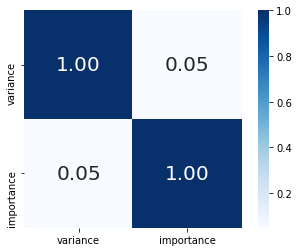

In [45]:
lst=np.array(range(320),dtype=np.float).reshape((2,160))

lst[0]=list(sorted_d1_train.values())
lst[1]=importance_list
 
df=pd.DataFrame({"variance":list(sorted_d1_train.values()),"importance":importance_list})
corr=df.corr(method='pearson')
print(corr)

import matplotlib.pyplot as plt 
import seaborn as sns

df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

##   
2. **Spearman 상관계수** 사용해 구함
    - 두 연속형 변수의 분포가 심각하게 정규분포를 벗어났거나 또는 두 변수가 순위 척도 자료일때 사용하는 상관계수
    - pearson상관계수와 달리 선형적인 상관 관계를 나타내지 않고 단수히 변수가 증가할 때 다른 변수가 증가하는지 감소하는지에 대한 관계만을 나타냄
  
  
    - 강도 : 상관 계수 값의 범위는 −1부터 +1까지이다

            variance  importance
variance    1.000000   -0.114409
importance -0.114409    1.000000


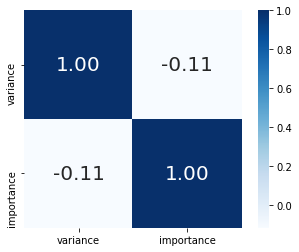

In [48]:
corr=df.corr(method='spearman')
print(corr)

import matplotlib.pyplot as plt 
import seaborn as sns

df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

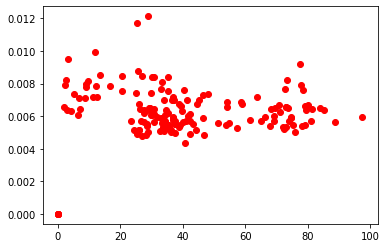

In [41]:
import matplotlib.pyplot as plt

plt.plot(lst[0], lst[1],"ro")
plt.show()

# **결과적으로, featureimportance에 variance가 영향을 미치지 못하므로 PCA를 이용한 feature 축소방식을 사용할 이유가 없다**